In [1]:
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('fivethirtyeight')

import pandas as pd

import imutils 
import cv2 
import os
from PIL import Image
from PIL import ImageEnhance
from tesserocr import PyTessBaseAPI, PSM, RIL
import sys
import re
# from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

%matplotlib inline 

In [2]:
class ShadowRemover():

    def __init__(self):
        # Default algorithmic parameters
        self.stride = 20;                 # Number of pixels to skip when performing local analysis
        self.blockSize = self.stride;     # Size of overlapping blocks in local analysis
        self.numOfClusters = 4;           # Number of clusters used for local analysis
        self.maxIters = 100;              # Maximum number of iterations used as stopping condition for GMM clustering. 
        self.emEps = 0.1;                # Epsilon threshold used as stopping condition for GMM clustering.
        self.diffThres = 30;
        self.clearThres = 40;


    def GetBlock(self, x, y, dsImage, width, height):
        minX = x
        maxX = min(width, x + self.blockSize)
        minY = y
        maxY = min(height, y + self.blockSize)
        block = np.array([dsImage[y][minX:maxX] for y in range(minY, maxY)])
        return block;

    def PutBlock(self, x, y, newImg, newBlock):
        for i in range(y, y + len(newBlock)):
            newImg[i][x:x+len(newBlock[i - y])] = newBlock[i - y]

    def ClusterBlock(self, block):
    #     X,Y = make_blobs(cluster_std=0.5,random_state=20,n_samples=1000,centers=5)
        # Stratch dataset to get ellipsoid data
        emModel = GaussianMixture(n_components=self.numOfClusters, covariance_type= 'diag', max_iter=self.maxIters, tol=self.emEps)
        originalShape = (len(block), -1)
        block_flat = block.reshape((-1, 1))

        if len(block_flat) < self.numOfClusters:
            dst = np.zeros_like(block)
            cv2.normalize(block, dst, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
            return None, None, dst

        samples = block_flat.copy()
        samples = np.array(samples)
        emModel.fit(samples)
        predict_probs = emModel.predict_proba(samples)

        means = emModel.means_ 
        covariances = emModel.covariances_

        order = sorted(range(len(means)), key = lambda x : means[x])
        means = np.array(sorted(means))
        predict_probs = np.array([[p[o] for o in order] for p in predict_probs])

        if (abs(means[0] - means[-1]) < self.clearThres):
            predicts = np.ones(len(predict_probs))
        else:
            lowest = means[0]
            highest = means[-1]
            values = np.array([int(abs(m - lowest) >= self.diffThres) * 1 * int(abs(m - highest) < self.diffThres) + min(1, 1.1 * (m - lowest) / (highest - lowest)) * int(abs(m - highest) >= self.diffThres and abs(m - lowest) >= self.diffThres) for m in means])
            predicts = []
            for p in predict_probs:
                predicts.append(np.dot(p, values))
            predicts = np.array(predicts)

        predicts = np.array([predicts * 255])
        return means, covariances, predicts.reshape(originalShape)

    # main function
    def RemoveShadow(self, image):
        width = len(image[0])
        height = len(image)

        newImg = image.copy()
        i = 0
        while i < height:
            j = 0
            while j < width:
                block = self.GetBlock(j, i, image, width, height)
                means, covariances, newBlock = self.ClusterBlock(block)
                self.PutBlock(j, i, newImg, newBlock)
                
                j += self.stride
            i += self.stride
        return newImg


class ImageProcessor():

    def __init__(self):
        self.shadowRemover = ShadowRemover()

    def findMatrices(self, matrix, edge):
        matrices = [matrix]
        left = [matrix]
        right = [matrix]
        bot = [matrix]
        top = [matrix]
        
        moveRight = lambda m: np.insert(np.delete(m,0,1), -1, 0, axis=1)
        moveLeft = lambda m: np.insert(np.delete(m,-1,1), 0, 0, axis=1)
        moveTop = lambda m: np.insert(np.delete(m,-1,0), 0, 0, axis=0)
        moveBot = lambda m: np.insert(np.delete(m,0,0), -1, 0, axis=0)

        def loop_side(l, f):
            for _ in range(len(l)):
                m = l.pop(0)
                m = f(m)
                l.append(m)
                matrices.append(m)

        for i in range(1, edge + 1):
            loop_side(right, moveRight)
            loop_side(left, moveLeft)
            loop_side(top, moveTop)
            loop_side(bot, moveBot)

            leftTop = moveTop(left[0])
            left.insert(0, leftTop)
            top.insert(0, leftTop)
            matrices.append(leftTop)
            
            rightTop = moveTop(right[0])
            right.insert(0, rightTop)
            top.append(rightTop)
            matrices.append(rightTop)
            
            leftBot = moveBot(left[-1])
            left.append(leftBot)
            bot.insert(0, leftBot)
            matrices.append(leftBot)
            
            rightBot = moveTop(right[-1])
            right.append(rightBot)
            top.append(rightBot)
            matrices.append(rightBot)

        return matrices
        
    def contrast_img(self, matrix):
        
        dst = np.zeros_like(matrix)
        cv2.normalize(matrix, dst, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        matrix = dst
        
        edge = 2
        matrices = self.findMatrices(matrix, edge)
        
        mean_matrix = np.sum(matrices, axis=0) / len(matrices)
        demean_matrices = np.array(matrices) - mean_matrix
        std_matrix = np.sum(demean_matrices ** 2, axis=0) ** 0.5
        mean_std = np.mean(std_matrix)
        
        judge_matrix_dark = np.where((matrix < mean_matrix) & (std_matrix > 0.8 * mean_std), matrix, 0)
        matrix = (matrix - 0.5 * judge_matrix_dark).astype('uint8')
        
        return matrix

    def init_resize(self, img):
        while len(img) > 2000 or len(img[0]) > 2000:
            img = cv2.resize(img, (int(len(img[0]) / 1.5), int(len(img) / 1.5)))
        return img

    def denoiseOnce(self, matrix, e):
        matrices = self.findMatrices(matrix, e)
        count_black = np.zeros_like(matrix).astype('int64')
        thres = min(e * 2, len(matrices) // 8)
        for m in matrices:
            count_black += np.where(m.astype('int64') < 200, 1, 0)

        matrix = np.where(count_black > thres, matrix, 255).astype('uint8')
        return matrix

    def denoise(self, matrix, edge = 2):
        for e in range(1, edge + 1):
            matrix = self.denoiseOnce(matrix, e)
        for e in range(edge - 1, 0, -1):
            matrix = self.denoiseOnce(matrix, e)
        rt = np.zeros_like(matrix).astype('int64')
        while not np.array_equal(rt, matrix):
            rt = matrix
            matrix = self.denoiseOnce(matrix, 1)
        return matrix
        

    def generateGray(self, img):
        img = self.init_resize(img)
        matrix = np.array(img) 
        matrix = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        matrix = cv2.GaussianBlur(matrix, (7, 7), 0.6)
        matrix = self.contrast_img(matrix)
        print("remove shadow")
        matrix = cv2.adaptiveThreshold(matrix, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY,
                                     101,
                                     25)
#         matrix = self.shadowRemover.RemoveShadow(matrix)
        rt = np.zeros_like(matrix).astype('int64')
        edge = min(min(len(matrix), len(matrix[0])) // 100, 4)
        print("denoise")
        matrix = self.denoise(matrix, edge)

        varM = cv2.Laplacian(matrix, cv2.CV_64F)
        rt = np.array(matrix).astype('uint8')
        print("done")

        return rt

    def process_image(self, scr_path, dst_path, dpi = 70):
        img_ori = cv2.imread(scr_path)
        result = self.generateGray(img_ori)
        Image.fromarray(result).save(dst_path, dpi=(dpi, dpi))
        return result



In [3]:
# img_ori = cv2.imread("../Jerry.in/bloodtest20.jpeg")
img_ori = cv2.imread("../Jerry.hard.in/c1-1.jpg")

img = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
Image.fromarray(img, "L").show()
result = ImageProcessor().generateGray(img_ori)
p = Image.fromarray(result, "L")
p.show()

remove shadow
denoise
done


In [4]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

Found 31 textline image components.
Found 248 word image components.
[2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]


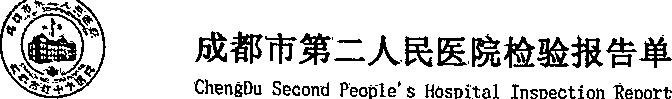

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[1, 0, 1, 1, 1, 0, 1, 0, 2, 0, 2, 1, 1, 0, 0]


[1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 0, 1, 0, 1, 0]


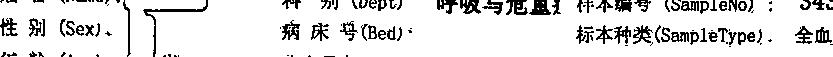

[0, 1, 1, 1, 2, 1, 1, 2, 0, 1, 0, 0, 0, 1, 1]


[0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]


[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0]


[1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]


[2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1]


[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]


[0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]


[0, 1, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1]


[1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0]


[0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1]


[1, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]


[1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]


[1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 1]


[0, 1, 0, 1, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]


[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]


[1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]


[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]


[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0]


[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]


[1, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0]


[1, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]


[0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0]


[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]


[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]


[0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]


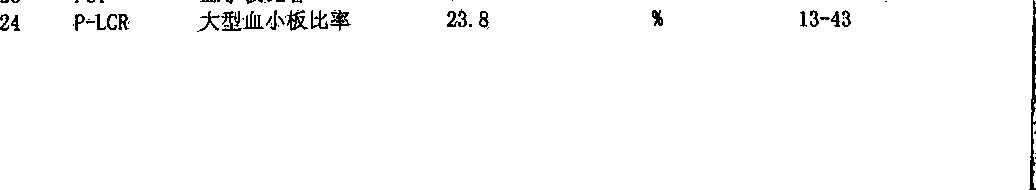

In [12]:
n_components = 15
from sklearn.cluster import KMeans


SYMBOLS = '()[]{}+-*/<=>^、~.,?!%;:#\'\"\\↑↓'
NUMBERS = '0123456789'
LETTERS = 'abcdefghigklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
CHARBASE = '序号英文名称中文名称结果状态单位参考值项目结果参考值单位简称参考范围单位检测方法检验项目测定结果区间提示备注代码缩写代号'



def getData(img):
    data = set()
    for j, row in enumerate(np.array(im)):
        for i, col in enumerate(row):
            if col < 90:
                data.add(i)
    data = [[x] for x in data]
    data = np.array(data)
    return data


# def getData(img):
#     thres = 3
#     data = set()
#     im = np.array(img)
#     for j in range(0, len(im), thres):
#         for i in range(0, len(im[0]), thres):
#             block = im[j:min(len(im), j + thres), i:min(len(im[0]), i + thres)]
#             sumblack = np.sum(block[block<100].astype(int))
#             if sumblack > 0:
#                 data.add(i + thres // 2)
#     data = [[x] for x in data]
#     data = np.array(data)
#     return data



image = Image.fromarray(result, "L")
image_2 = cv2.cvtColor(np.array(image), cv2.COLOR_GRAY2RGB)
with PyTessBaseAPI(lang='chi_sim',psm=6) as api:
    api.SetVariable('tessedit_char_whitelist',''.join(set('<=-～()+-abcdefghijklmnopqrstuvwxyz/\
                葡萄糖白细胞计数中性目百变异系标准差网织率总比↑\
                ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890.\
                %淋巴细胞单核嗜酸粒碱绝对值红蛋血压积平均量\
                浓度分布宽小板体性沉大肺炎支原反应' + SYMBOLS + NUMBERS + LETTERS + CHARBASE)))
    api.SetVariable('preserve_interword_spaces','1')
    api.SetImage(Image.fromarray(result, "L"))
#     text = api.GetUTF8Text()
    lines = api.GetComponentImages(RIL.TEXTLINE, True) # 查找图像内图像块，并将分割后的图像块返回到boxes迭代器中
    words = api.GetComponentImages(RIL.WORD, True)
    wordI = 0
    print('Found {0} textline image components.'.format(len(lines)))
    print('Found {0} word image components.'.format(len(words)))
    for i, (im, box, _, _) in enumerate(lines):
        emModel = GaussianMixture(n_components=n_components, covariance_type= 'diag', max_iter=10000, tol=0.001)
        x, y, w, h = box['x'], box['y'], box['w'], box['h']
        
#         print(x, y, w, h)
        
        data = getData(img)
#         print(data)
#         k, _ = optimalK(data, nrefs=1, maxClusters=8)
#         emModel = GaussianMixture(n_components=k + 1, covariance_type= 'diag', max_iter=10000, tol=0.001)
        emModel.fit(data)
        
        
#         data = np.array(emModel.means_)
#         k, _ = optimalK(data, nrefs=1, maxClusters=n_components)
#         emModel = GaussianMixture(n_components=k + 1, covariance_type= 'diag', max_iter=10000, tol=0.001)
#         emModel.fit(data)
        
        clusters = [[] for _ in range(len(emModel.means_))]
        for x_cluster_l in emModel.means_:
            x_cluster = x_cluster_l[0]
            cv2.rectangle(image_2, (x + int(x_cluster), y + h // 2), (x + int(x_cluster) + 1, y + h // 2 + 1), (0, 0, 255), 2)
        while wordI < len(words):
            try:
                im_w, box_w, _, _ = words[wordI]
                x_w, y_w, w_w, h_w = box_w['x'], box_w['y'], box_w['w'], box_w['h']
                cv2.rectangle(image_2, (x_w, y_w), (x_w + w_w, y_w + h_w), (255, 0, 0), 1)
                box_mean = [x_w + w_w // 2, y_w + h_w // 2]
#                 print(box_mean)
                if not(box_mean[0] > x and box_mean[0] < x + w and box_mean[1] > y and box_mean[1] < y + h):
#                     print(box_mean[0], x, box_mean[1], y)
                    break
                wordI += 1
                predict = emModel.predict(np.array([[box_mean[0] - x]]))[0]
                clusters[predict].append([x_w, y_w, w_w + x_w, h_w + y_w])
            except StopIteration:
                break
        print([len(x) for x in clusters])
        display(im)
        new_boxes = []
        for c in clusters:
            if len(c) > 0:
                dim = list(zip(*c))
                x_c, y_c, xe_c, ye_c = min(dim[0]), min(dim[1]), max(dim[2]), max(dim[3])
                new_boxes.append([x_c, y_c, xe_c, ye_c])
                cv2.rectangle(image_2, (x_c, y_c), (xe_c, ye_c), (0, 255, 0), 2)
        
        


Image.fromarray(image_2, "RGB").show()



In [ ]:
SYMBOLS = '()[]{}+-*/<=>^、~.,?!%;:#\'\"\\↑↓'
NUMBERS = '0123456789'
LETTERS = 'abcdefghigklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
CHARBASE = '序号英文名称中文名称结果状态单位参考值项目结果参考值单位简称参考范围单位检测方法检验项目测定结果区间提示备注代码缩写代号'





with PyTessBaseAPI(lang='chi_sim',psm=6) as api:
    api.SetVariable('tessedit_char_whitelist',''.join(set('<=-～()+-abcdefghijklmnopqrstuvwxyz/\
                葡萄糖白细胞计数中性目百变异系标准差网织率总比↑\
                ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890.\
                %淋巴细胞单核嗜酸粒碱绝对值红蛋血压积平均量\
                浓度分布宽小板体性沉大肺炎支原反应' + SYMBOLS + NUMBERS + LETTERS + CHARBASE)))
    api.SetVariable('preserve_interword_spaces','1')
    api.SetImage(Image.fromarray(result, "L"))
    text = api.GetUTF8Text()
    boxes = api.GetComponentImages(RIL.WORD, True) # 查找图像内图像块，并将分割后的图像块返回到boxes迭代器中
    print('Found {0} textline image components.'.format(len(boxes)))
#     for i, (im, box, _, _) in enumerate(boxes):
#         x, y, w, h = box['x'], box['y'], box['w'], box['h']
#         cv2.rectangle(image_2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    
    

In [12]:
text.split("\n")

['e        大代区检验单',
 "ES           Chengpu Second Peohitie's Hospital Inspection Report",
 ' 名 ane)          简 Ooepb  ; 检号 (SampleNol ; 343',
 '性 区(Sex)、 ] 计(Bed)*              标(SampleTypel . 血',
 ' (Agejz        写(PatNG) :             间检区poctor),',
 '英(SickTypaj    果(Diag} ; 肺',
 '序号 文名称    中文名称              结果        状态 单位         参考值',
 '1       WBC 细胞计数             9. 33      #10 9/L      3,5-9.2',
 '2      RNEUT%       中性分核粒胞百分数 77. 2            50-70',
 '3         LYMPH%        淋巴细胞分数              14.9             L         网                   20-40',
 '4           MONO%            单核细胞分数                7.9                      3-10',
 '5      EM        嗜酸性粒细胞百分数 ( 2.4            0.5-5',
 '6         BASON          嗜碱性粒细胞百分数        0.6                   0-1',
 '?      NEUTS      中性分核粒细胞绝对数 7 20     #10"9/L      2-7',
 '8         ESMPH#        注细胞绝对数             1. 11                      提0 9/L         0. 8-4',
 '9        ONOH         单核细胞绝对数            0. 4                     #

In [6]:
# import imutils 
# # load the image and compute the ratio of the old height
# # to the new height, clone it, and resize it
# image = cv2.imread("../Jerry.in/bloodtest20.jpeg")
# ratio = image.shape[0] / 500.0
# orig = image.copy()
# image = imutils.resize(image, height = 500)
 
# # convert the image to grayscale, blur it, and find edges
# # in the image
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray, (5, 5), 0)
# edged = cv2.Canny(gray, 75, 200)
 
# # show the original image and the edge detected image
# print("STEP 1: Edge Detection")
# Image.fromarray(image, "RGB").show()
# Image.fromarray(edged, "L").show()


# # find the contours in the edged image, keeping only the
# # largest ones, and initialize the screen contour
# cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
# cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# screenCnt = []

# # loop over the contours
# for c in cnts:
#     # approximate the contour
#     peri = cv2.arcLength(c, True)
#     approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
#     # if our approximated contour has four points, then we
#     # can assume that we have found our screen
#     if len(approx) == 4:
#         screenCnt = approx
#         break
# if len(screenCnt) != 0:
#     # show the contour (outline) of the piece of paper
#     print("STEP 2: Find contours of paper")
#     cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
#     cv2.imshow("Outline", image)

STEP 1: Edge Detection


In [20]:
from tesserocr import PyTessBaseAPI, PSM, RIL
import imutils
 
with PyTessBaseAPI(psm=PSM.AUTO_OSD) as api:
#     image = Image.open("/usr/src/tesseract/testing/eurotext.tif")
    api.SetImage(Image.fromarray(result, "L"))
    api.Recognize()
 
    it = api.AnalyseLayout() # 对目标页面进行分析
    orientation, direction, order, deskew_angle = it.Orientation() # 获取页面和文字方向
    print("Orientation: {:d}".format(orientation))
    print("WritingDirection: {:d}".format(direction))
    print("TextlineOrder: {:d}".format(order))
    print("Deskew angle: {:.4f}".format(deskew_angle))
    result = imutils.rotate(result, 0.8)
    Image.fromarray(result, "L").show()

Orientation: 0
WritingDirection: 0
TextlineOrder: 2
Deskew angle: 0.0084


In [8]:
from tesserocr import PyTessBaseAPI, PSM, RIL

SYMBOLS = '()[]{}+-*/<=>^、~.,?!%;:#\'\"\\↑↓'
NUMBERS = '0123456789'
LETTERS = 'abcdefghigklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
CHARBASE = '序号英文名称中文名称结果状态单位参考值项目结果参考值单位简称参考范围单位检测方法检验项目测定结果区间提示备注代码缩写代号'


image = Image.fromarray(result, "L")
image_2 = cv2.cvtColor(np.array(image), cv2.COLOR_GRAY2RGB)
with PyTessBaseAPI(lang='chi_sim') as api:
    api.SetImage(image)
    api.SetVariable('tessedit_char_whitelist',''.join(set('<=-～()+-abcdefghijklmnopqrstuvwxyz/\
                葡萄糖白细胞计数中性目百变异系标准差网织率总比↑\
                ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890.\
                %淋巴细胞单核嗜酸粒碱绝对值红蛋血压积平均量\
                浓度分布宽小板体性沉大肺炎支原反应' + SYMBOLS + NUMBERS + LETTERS + CHARBASE)))
#     api.SetVariable('preserve_interword_spaces','1')


    boxes = api.GetComponentImages(RIL.WORD, True) # 查找图像内图像块，并将分割后的图像块返回到boxes迭代器中
    print('Found {0} textline image components.'.format(len(boxes)))
    for i, (im, box, _, _) in enumerate(boxes):
#         display(im)
#         print("======================================")
        
        x, y, w, h = box['x'], box['y'], box['w'], box['h']
        cv2.rectangle(image_2, (x, y), (x + w, y + h), (0, 255, 0), 2)
# #         print(x, y, w, h)
#         #im 是一个PIL图像对象
#         #box 是一个键包括x, y, w, h的词典
# #         api.SetRectangle(x, y, w, h)
# #         ocrResult = api.GetUTF8Text() # 输出指定区域内的UTF-8编码的文本
# #         conf = api.MeanTextConf() # 输出文本的确信度
#         block = np.array(image)[y:y+h+1, x:x+w + 1]
#         sub_image = Image.fromarray(block, "L")
       
# #     for i_c, (img_c, box) in enumerate(components):
# #         display(img_c)
Image.fromarray(image_2, "RGB").show()
    

Found 244 textline image components.


In [6]:
# from tesserocr import PyTessBaseAPI, PSM, RIL

# SYMBOLS = '()[]{}+-*/<=>^、~.,?!%;:#\'\"\\↑↓'
# NUMBERS = '0123456789'
# LETTERS = 'abcdefghigklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
# CHARBASE = '序号英文名称中文名称结果状态单位参考值项目结果参考值单位简称参考范围单位检测方法检验项目测定结果区间提示备注代码缩写代号'


# image = Image.fromarray(result, "L")
# with PyTessBaseAPI(lang='chi_sim') as api:
#     api.SetImage(image)
# #     components = api.GetConnectedComponents()
# #     print(components)
#     api.SetVariable('tessedit_char_whitelist',''.join(set('<=-～()+-abcdefghijklmnopqrstuvwxyz/\
#                 葡萄糖白细胞计数中性目百变异系标准差网织率总比↑\
#                 ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890.\
#                 %淋巴细胞单核嗜酸粒碱绝对值红蛋血压积平均量\
#                 浓度分布宽小板体性沉大肺炎支原反应' + SYMBOLS + NUMBERS + LETTERS + CHARBASE)))
# #     api.SetVariable('preserve_interword_spaces','1')
#     components = api.GetConnectedComponents()
# #     print(components)
# #     print(zip(*components))
#     for i, (im, component) in enumerate(components):
#         display(im)
# #         print("---------------")b


# #     boxes = api.GetComponentImages(RIL.TEXTLINE, True) # 查找图像内图像块，并将分割后的图像块返回到boxes迭代器中
# #     print('Found {0} textline image components.'.format(len(boxes)))
# #     for i, (im, box, _, _) in enumerate(boxes):
# # #         display(im)
# # #         with PyTessBaseAPI(lang='chi_sim') as api_2:
# # #             api_2.SetImage(im)
# # #             api_2.SetVariable('preserve_interword_spaces','1')
# # #             words = api_2.GetWords()
# # #             print(words)
# # # #             for i_2, (im_2, word) in enumerate(words):
# # # #                 display(im_2)
# # # #                 print("---------------")
# #         print("======================================")
        
# #         x, y, w, h = box['x'], box['y'], box['w'], box['h']
# # #         print(x, y, w, h)
# #         #im 是一个PIL图像对象
# #         #box 是一个键包括x, y, w, h的词典
# # #         api.SetRectangle(x, y, w, h)
# # #         ocrResult = api.GetUTF8Text() # 输出指定区域内的UTF-8编码的文本
# # #         conf = api.MeanTextConf() # 输出文本的确信度
# #         block = np.array(image)[y:y+h+1, x:x+w + 1]
# #         sub_image = Image.fromarray(block, "L")
        
        
# #         display(sub_image)
# # #         with PyTessBaseAPI(lang='chi_sim') as api_2:
# # #             api_2.SetImage(sub_image)
# # # #             api_2.SetVariable('preserve_interword_spaces','1')
# # #             block_boxes = api_2.GetComponentImages(RIL.WORD, True)
# # #             print('    Found {0} word image components within block.'.format(len(block_boxes)))
# # #             for block_i, (block_im, block_box, _, _) in enumerate(block_boxes):
# # #                 block_x, block_y, block_w, block_h = block_box['x'], block_box['y'], block_box['w'], block_box['h']
# # #         #         print(x, y, w, h)
# # #                 #im 是一个PIL图像对象
# # #                 #box 是一个键包括x, y, w, h的词典
# # #         #         api.SetRectangle(block_x, block_y, block_w, block_h)
# # #         #         ocrResult = api.GetUTF8Text() # 输出指定区域内的UTF-8编码的文本
# # #         #         conf = api.MeanTextConf() # 输出文本的确信度
# # #                 block_word = block[block_y:block_y+block_h+1, block_x:block_x+block_w + 1]
# # #                 sub_image_word = Image.fromarray(block_word, "L")
# # #                 display(sub_image_word)
        
# # #         print("------------------------------")
# # #     for i_c, (img_c, box) in enumerate(components):
# # #         display(img_c)
    

In [7]:
# # Save image in set directory 
# # Read RGB image 
# p = "../Jerry.in"

# matrices = []
# for r,d,f in os.walk(p):
#     for file_name in f:
#         if (not file_name.endswith(".jpeg") and not file_name.endswith(".jpg") and not file_name.endswith(".png")):
#             continue
#         print(p + "/" + file_name)
#         scr_path = p + "/" + file_name
#         postfix = file_name.split(".")[-1]
#         main_name = ".".join(file_name.split(".")[:-1])
#         dst_path = '../Jerry.out/' + main_name + ".out.png"
#         rt = ImageProcessor().process_image(scr_path, dst_path, dpi = 70)
#         Image.fromarray(rt).show()
        
        
        